In [67]:
#Imports
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import datetime as dt
import time
from datetime import date, timedelta
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy.stats import poisson
import scipy.stats as stats
%matplotlib inline

from google.oauth2.service_account import Credentials
import google_auth_httplib2
import pygsheets
import df2gspread as d2g
import googleapiclient
from googleapiclient  import discovery
from httplib2 import Http
from oauth2client import file, client, tools
from gspread_formatting.dataframe import format_with_dataframe, BasicFormatter
from gspread_formatting import Color
import logging

from oauth2client.service_account import ServiceAccountCredentials
from google.oauth2 import service_account
import gslides
from gslides import (Frame,Presentation,Spreadsheet,Table,Series,Chart)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import sqlalchemy as db
from sqlalchemy import create_engine
import mysql.connector
import psycopg2

# GBQ logging
import logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.fitters.modified_beta_geo_fitter import ModifiedBetaGeoFitter
from lifetimes import ParetoNBDFitter
from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_expected_repeat_purchases
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
import datetime as dt
from numpy import log as ln

from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random

In [4]:
path = 'C:/Users/mncedisi.mncwabe/Documents/Connect to BQ/tal-production-data-4390ad039b75.json'
credentials=Credentials.from_service_account_file(path)

path2 = 'C:/Users/mncedisi.mncwabe/Downloads/tal-production-marketing-e93d689c8a94.json'
cre_marketing=Credentials.from_service_account_file(path2)

In [112]:
start_time = time.time()

query_elasticity = '''
SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2021-04'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) a
UNION ALL
SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2021-05'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) b
UNION ALL
SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2021-06'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) c
UNION ALL
SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2021-07'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) d
UNION ALL
SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2021-08'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) e
UNION ALL
SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2021-09'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) f
UNION ALL
SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2021-10'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) g
    UNION ALL
SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2021-11'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) h
    UNION ALL
    SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2021-12'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) i
UNION ALL
SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2022-01'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) j
UNION ALL
SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2022-02'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) k
UNION ALL
SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2022-03'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) l
UNION ALL
SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2022-04'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) m
UNION ALL
SELECT *
FROM (
SELECT  bh.tsin_id AS idTsin,
        FORMAT_DATE("%Y-%m",o.order_authed_timestamp) AS YearMonth,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        oi.sold_price AS UnitPrice,
        SUM(oi.order_item_sales) AS GMV,
        SUM(oi.order_item_quantity) AS Qty,
        ROUND(SUM(oi.order_item_sales)/COUNT(DISTINCT o.order_id),2) AS AOV, 
        ROUND(SUM(oi.order_item_sales)/SUM(oi.order_item_quantity),2) AS AISP, 
        ROUND(SUM(oi.order_item_quantity)/COUNT(DISTINCT o.order_id),2) AOU
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2021-04-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2021-04-01" AND DATE(o.order_authed_timestamp) < "2022-06-01"
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'
        AND oi.is_retail_item=true
        AND bh.bh_division NOT IN ('Specials')
        AND oi.sold_price IS NOT NULL
        AND FORMAT_DATE("%Y-%m",o.order_authed_timestamp)='2022-05'
    GROUP BY 1,2,3,4,5
    ORDER BY GMV DESC
     LIMIT 2000) n
'''
df_elasticity = pd.read_gbq(query_elasticity, project_id='gcp-takealot', dialect='standard', credentials=credentials,progress_bar_type='tqdm_notebook')

print("--- %s seconds ---" % (time.time() - start_time))

Requesting query... 
Requesting query... 
Requesting query... 
2022-06-30 01:30:30,606 : DEBUG : Requesting query... 
Query running...
Query running...
Query running...
2022-06-30 01:30:34,137 : DEBUG : Query running...
Job ID: 7a6bed87-9d01-41ec-8cf8-6809d0e78c95
Job ID: 7a6bed87-9d01-41ec-8cf8-6809d0e78c95
Job ID: 7a6bed87-9d01-41ec-8cf8-6809d0e78c95
2022-06-30 01:30:34,137 : DEBUG : Job ID: 7a6bed87-9d01-41ec-8cf8-6809d0e78c95
  Elapsed 13.63 s. Waiting...
  Elapsed 13.63 s. Waiting...
  Elapsed 13.63 s. Waiting...
2022-06-30 01:30:44,232 : INFO :   Elapsed 13.63 s. Waiting...
  Elapsed 24.58 s. Waiting...
  Elapsed 24.58 s. Waiting...
  Elapsed 24.58 s. Waiting...
2022-06-30 01:30:55,189 : INFO :   Elapsed 24.58 s. Waiting...
  Elapsed 34.79 s. Waiting...
  Elapsed 34.79 s. Waiting...
  Elapsed 34.79 s. Waiting...
2022-06-30 01:31:05,399 : INFO :   Elapsed 34.79 s. Waiting...
  Elapsed 44.92 s. Waiting...
  Elapsed 44.92 s. Waiting...
  Elapsed 44.92 s. Waiting...
2022-06-30 01:31:

Downloading:   0%|          | 0/28000 [00:00<?, ?rows/s]

Got 28000 rows.

Got 28000 rows.

Got 28000 rows.

2022-06-30 01:31:38,093 : DEBUG : Got 28000 rows.

Total time taken 67.49 s.
Finished at 2022-06-30 01:31:38.
Total time taken 67.49 s.
Finished at 2022-06-30 01:31:38.
Total time taken 67.49 s.
Finished at 2022-06-30 01:31:38.
2022-06-30 01:31:38,094 : INFO : Total time taken 67.49 s.
Finished at 2022-06-30 01:31:38.


--- 67.51346635818481 seconds ---


In [113]:
df_elasticity['GMV'] = round(np.floor(pd.to_numeric(df_elasticity['GMV'], errors='coerce')).astype('float64'),0)
df_elasticity['AOV'] = round(np.floor(pd.to_numeric(df_elasticity['AOV'], errors='coerce')).astype('float64'),0)
df_elasticity['AISP'] = round(np.floor(pd.to_numeric(df_elasticity['AISP'], errors='coerce')).astype('float64'),0)
df_elasticity['UnitPrice'] = round(np.floor(pd.to_numeric(df_elasticity['UnitPrice'], errors='coerce')).astype('float64'),0)
df_elasticity['idTsin'] = df_elasticity['idTsin'].astype(str)

In [114]:
df_elasticity['Item'] = df_elasticity[['idTsin', 'Title']]\
                                     .apply(lambda x: ' - '.join(x), axis=1)

KeyError: "['Title'] not in index"

In [121]:
# count unique unit prices for each TSIN
df_items = df_elasticity.groupby(['idTsin','Division','Department'])\
             .agg({
                   'UnitPrice': ['nunique', 'count', 'mean', 'min', 'max'],
                   'GMV':'sum',
                    'Qty':'sum',
                     'AOV':'mean',
                      'AOU':'mean'})\
             .reset_index()
# rename columns - merge multi-level columns from agg
df_items.columns = [level1+level2.title() if level2!='' else level1\
                    for level1, level2 in df_items.columns ]
df_items.sort_values(by=['UnitPriceNunique', 'UnitPriceCount'],
                     ascending=False, inplace=True)
df_items.head()

,idTsin,Division,Department,UnitPriceNunique,UnitPriceCount,UnitPriceMean,UnitPriceMin,UnitPriceMax,GMVSum,QtySum,AOVMean,AOUMean
109,30566437,Consumables,Pets,23,42,760.380952,649.0,860.0,4837994.0,7385,761.809524,1.154524
106,30566395,Consumables,Pets,21,49,490.897959,400.0,575.0,10637262.0,25579,530.040816,1.244286
1550,57639337,Consumables,Pets,21,37,403.729730,340.0,509.0,4238894.0,12328,440.297297,1.260270
3600,75657924,Electronics,Computers & Laptops,19,35,5024.514286,4399.0,5499.0,26969487.0,6097,4741.857143,1.086000
1836,60055134,Home,Small Appliances,18,26,7228.769231,6399.0,8699.0,3675108.0,587,6315.000000,1.008846


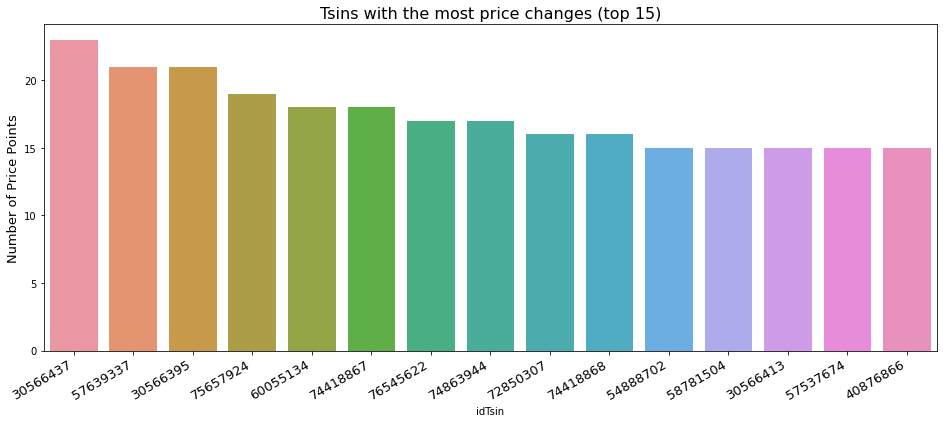

In [123]:
top_unit_price = df_items.sort_values(by='UnitPriceNunique',ascending=False)[:15]



plt.figure(figsize=(16,6))
sns.barplot(x='idTsin', y='UnitPriceNunique', data=top_unit_price)
plt.title('Tsins with the most price changes (top 15)', fontsize=16)
plt.ylabel('Number of Price Points', fontsize=13)
plt.ticklabel_format(style='plain', axis='y'); # set scientific notation off
plt.xticks(rotation=30, ha='right', fontsize=13)
plt.show()

In [125]:
# get TSins with 2 or more unique unit prices and sum the demand at each unique unit price
df_items_sub = df_items[(df_items['UnitPriceNunique']>=2)]

df_sub = df_elasticity[df_elasticity['idTsin'].isin(df_items_sub['idTsin'].tolist())]\
                           .reset_index(drop=True)

# Get total quantity at each unit price for each item/product
df_agg = df_sub.groupby(['idTsin','Division','Department','UnitPrice','AISP','GMV','AOV','AOU'])['Qty']\
               .sum()\
               .reset_index()\
               .rename(columns={'Qty': 'TotalQuantity'})

In [126]:
df_agg

,idTsin,Division,Department,UnitPrice,AISP,GMV,AOV,AOU,TotalQuantity
0,15164295,Home,Office,319.0,277.0,49652.0,304.0,1.10,179
1,15164295,Home,Office,319.0,277.0,51594.0,301.0,1.09,186
2,15164295,Home,Office,329.0,286.0,42913.0,335.0,1.17,150
3,15253247,Consumables,Consumer Beauty,949.0,825.0,79221.0,842.0,1.02,96
4,15253247,Consumables,Consumer Beauty,999.0,872.0,60201.0,885.0,1.01,69
...,...,...,...,...,...,...,...,...,...
23984,90705954,Media,Stationery,6999.0,6086.0,85205.0,6086.0,1.00,14
23985,90705958,Home,Large Appliances,6999.0,6103.0,280739.0,6103.0,1.00,46
23986,90705958,Home,Large Appliances,7895.0,6865.0,61786.0,6865.0,1.00,9
23987,<NA>,Other,Other,129.0,112.0,41615.0,115.0,1.03,371


In [131]:
df_agg = df_agg[df_agg['idTsin']!='<NA>']

In [134]:
df_agg['TotalQuantity'] = round(np.floor(pd.to_numeric(df_agg['TotalQuantity'], errors='coerce')).astype('float64'),0)

In [132]:
df_agg['idTsin'] = df_agg['idTsin'].astype(int)

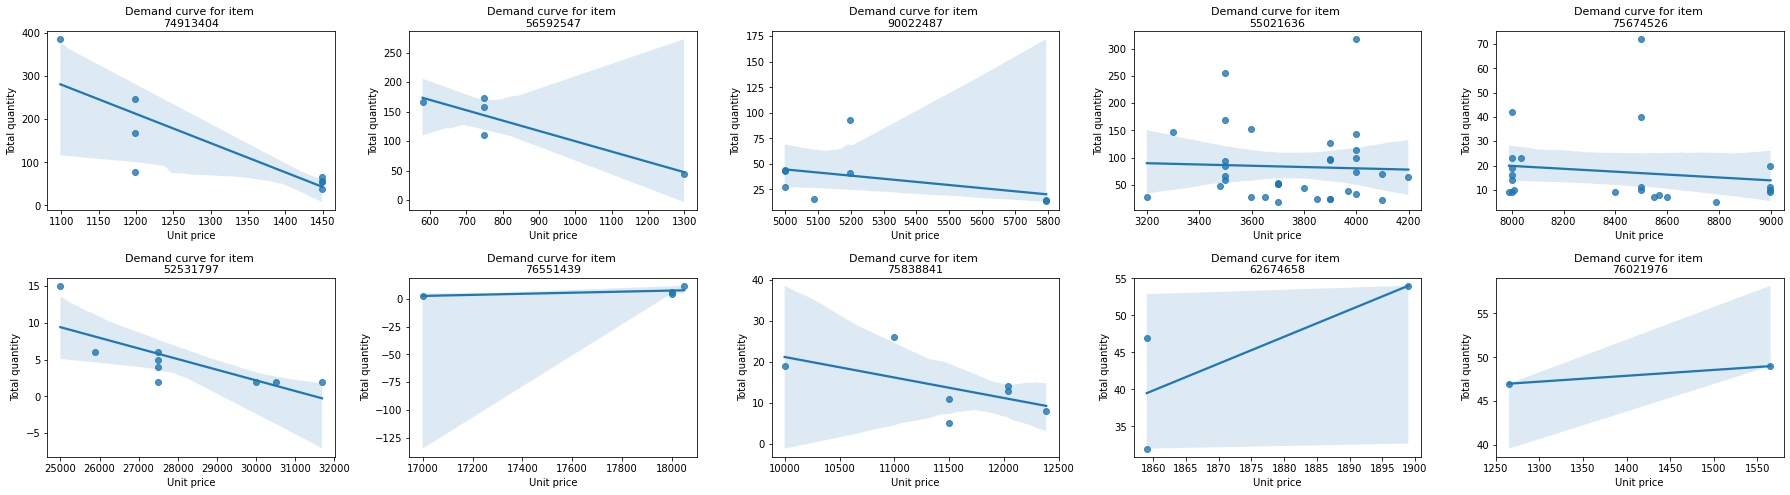

In [135]:
def plot_demand_curve(df, item_col, quantity_col, price_col, n=10):
    '''randomly select n items from a dataframe to plot each
       item's / Tsin's demand curve
       '''
    fig, ax = plt.subplots(2, 5, figsize=(25, 7))
    ax = ax.ravel()
    
    #randomly choose n items to be plotted
    items_to_plot = random.sample(df[item_col].unique().tolist(),n)     
    
     # plot demand vs unit price 
    for i, item in enumerate(items_to_plot):
        sns.regplot(x=price_col, y=quantity_col, data=df[df[item_col]==item], ax=ax[i])
        ax[i].set_title('Demand curve for item \n' +str(item), fontsize=11, loc='center', wrap=True)
        ax[i].set_xlabel('Unit price')
        ax[i].set_ylabel('Total quantity')
    plt.tight_layout()
    plt.show()

plot_demand_curve(df_agg, 'idTsin', 'TotalQuantity', 'UnitPrice')

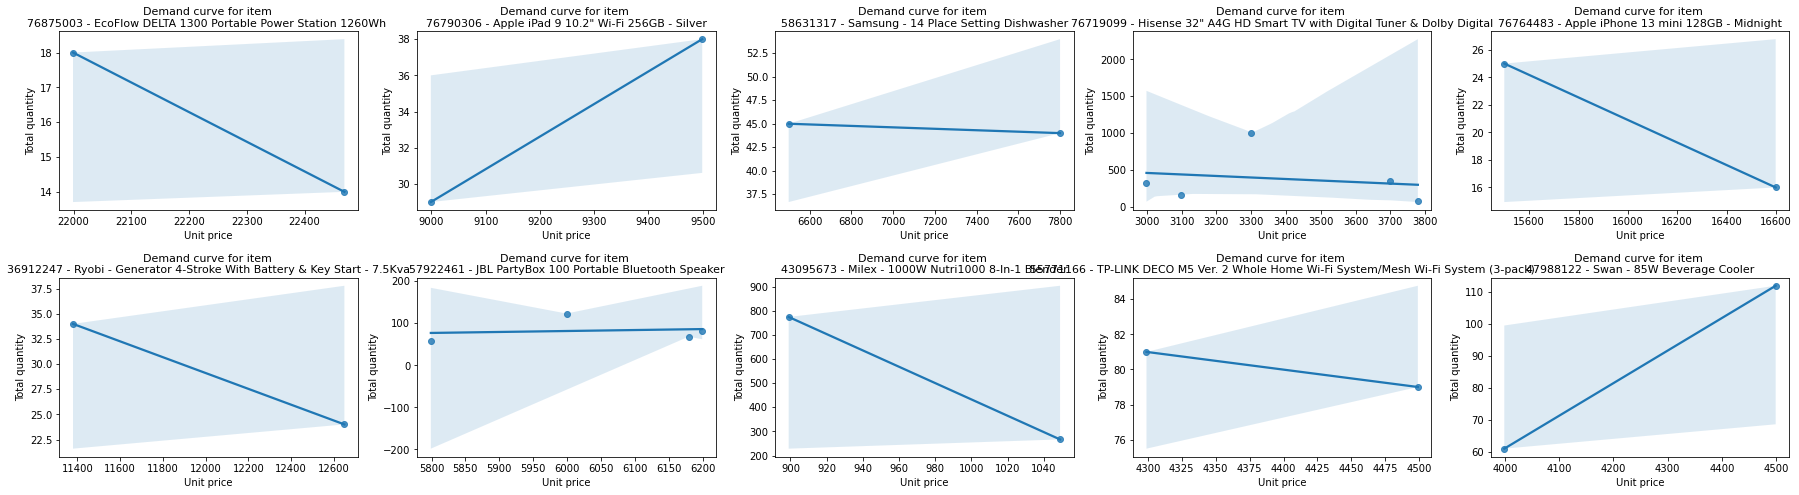

In [111]:
# demand curves with idTsin  + Titles
def plot_demand_curve(df, item_col, quantity_col, price_col, n=10):
    '''randomly select n items from a dataframe to plot each
       item's / Tsin's demand curve
       '''
    fig, ax = plt.subplots(2, 5, figsize=(25, 7))
    ax = ax.ravel()
    
    #randomly choose n items to be plotted
    items_to_plot = random.sample(df[item_col].unique().tolist(),n)     
    
     # plot demand vs unit price for these n items
    for i, item in enumerate(items_to_plot):
        sns.regplot(x=price_col, y=quantity_col, data=df[df[item_col]==item], ax=ax[i])
        ax[i].set_title('Demand curve for item \n' +str(item), fontsize=11, loc='center', wrap=True)
        ax[i].set_xlabel('Unit price')
        ax[i].set_ylabel('Total quantity')
    plt.tight_layout()
    plt.show()

plot_demand_curve(df_agg, 'Item', 'TotalQuantity', 'UnitPrice')

In [136]:
def get_elasticity(df, quantity_col, price_col):
    '''fits linear regression for one item, quantity_col is
       used as outcome variable and price_col as independent variable
       returns intercept, slope, p-value of regression, and also
       price elasticity
       '''
    
    #regress quantity over price to estimate price elasticity
    reg_fit = ols(formula=quantity_col+' ~ '+price_col, data=df).fit()
    
    # extract intercept slope and p-value from model parameters
    intercept = reg_fit.params['Intercept']
    slope = reg_fit.params[price_col]
    p_value = reg_fit.pvalues.loc[price_col] 
    rsquared = reg_fit.rsquared
    std_err = reg_fit.bse[price_col]
    #conf_int = reg_fit.conf_int().rename(columns={0: 'lower', 1: 'upper'})
    
    # calculate elasticity - slope*(mean price/mean quantity)
    elasticity = slope * (df[price_col].mean() / df[quantity_col].mean())
    
    
    return intercept, slope, p_value, elasticity, rsquared, std_err

In [137]:
def get_multiple_elasticity(df, item_id_col, quantity_col, price_col):
    '''runs linear regression for multiple items in a df
       returns a separate df with item id, elasticity,
       p-value, and whether price is a significant predictor of 
       quantity
    '''
    elasticity_results = []
     
    for item_id in df[item_id_col].unique():
        elasticity = {}
        # subset rows with item_id
        df_single_item = df[df[item_id_col]==item_id]
        # store intercept slope and p-value in dict
        elasticity['idTsin'] = item_id
        elasticity['Intercept'], elasticity['Slope'], elasticity['PValue'], elasticity['Elasticity'], elasticity['Rsquared'], elasticity['Std_Err']\
               = get_elasticity(df_single_item, quantity_col, price_col)
        elasticity_results.append(elasticity)
        
        df_elasticity = pd.DataFrame(elasticity_results).set_index('idTsin')
        # use p <.05 as cutoff for significance
        df_elasticity['Significant'] = df_elasticity['PValue'].apply(lambda x:
                                                                     'Yes' if x < 0.05 else 'No')
        
    return df_elasticity

In [138]:
# get elasticity for all items 

start_time = time.time()

df_elasticity = get_multiple_elasticity(df_agg, 'idTsin', 'TotalQuantity', 'UnitPrice')
df_elasticity = df_elasticity.merge(df_agg[['idTsin','Division','Department']].drop_duplicates(), on='idTsin', how='left')

print("--- %s seconds ---" % (time.time() - start_time))
df_elasticity.head()

--- 26.149386644363403 seconds ---


,idTsin,Intercept,Slope,PValue,Elasticity,Rsquared,Std_Err,Significant,Division,Department
0,15164295,1219.250000,-3.250000,0.117399,-6.102427,0.966377,0.606218,No,Home,Office
1,15253247,608.460000,-0.540000,NaN,-6.375273,1.000000,inf,No,Consumables,Consumer Beauty
2,15253337,1116.780751,-1.524413,0.406384,-2.884455,0.352380,1.461311,No,Consumables,Consumer Beauty
3,15253339,-91.010000,0.190000,0.057875,2.026429,0.991758,0.017321,No,Consumables,Consumer Beauty
4,15253899,412.515789,-0.431579,0.461975,-2.256704,0.559587,0.382874,No,Consumables,Consumer Beauty


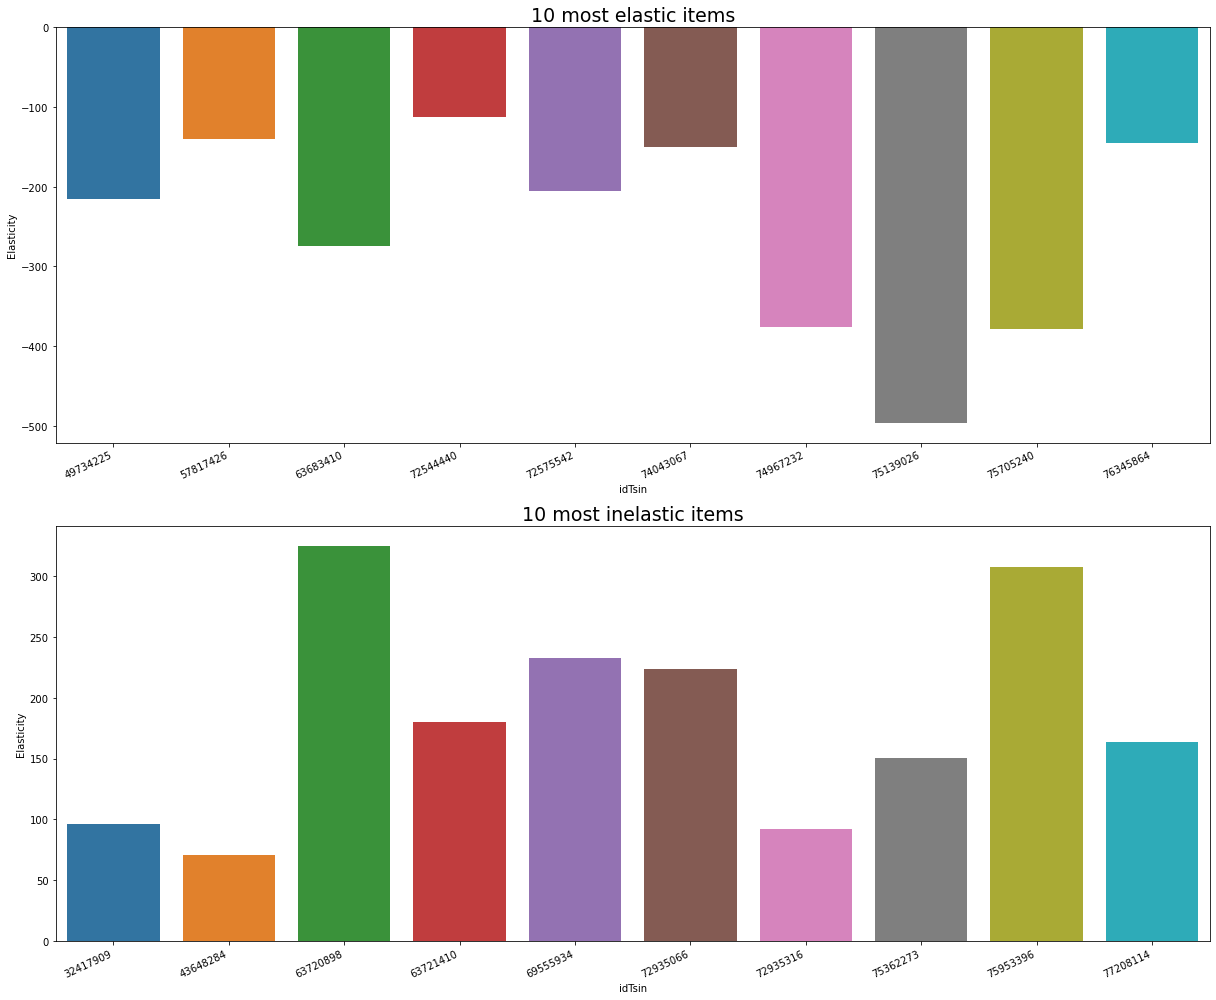

In [140]:
# subset items with significant p-value
#df_elasticity = df_elasticity[df_elasticity['Significant']=='Yes']
#df_elasticity['Item'] = df_elasticity[['idTsin', 'Title']]\
                                     #.apply(lambda x: ' '.join(x), axis=1)

df_most_elastic = df_elasticity.sort_values(by='Elasticity')[:10]
df_least_elastic = df_elasticity.sort_values(by='Elasticity',
                                             ascending=False)[:10]

fig, axes = plt.subplots(2, 1, figsize=(17, 14))
sns.barplot(x='idTsin', y='Elasticity', data=df_most_elastic, ax=axes[0])
axes[0].set_title('10 most elastic items', fontsize=19)
sns.barplot(x='idTsin', y='Elasticity', data=df_least_elastic, ax=axes[1])
axes[1].set_title('10 most inelastic items', fontsize=19)
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(25)
        label.set_horizontalalignment("right")
plt.tight_layout()
plt.show() 

In [141]:
df_elasticity['PED Status'] = np.where(df_elasticity['Elasticity'] <= -5, 'Highly Elastic'
        ,np.where((df_elasticity['Elasticity']>-5) & (df_elasticity['Elasticity']<=-2),'Elastic'
        ,np.where((df_elasticity['Elasticity']>-2) & (df_elasticity['Elasticity']<0),'Unit-Elastic','Inelastic')))

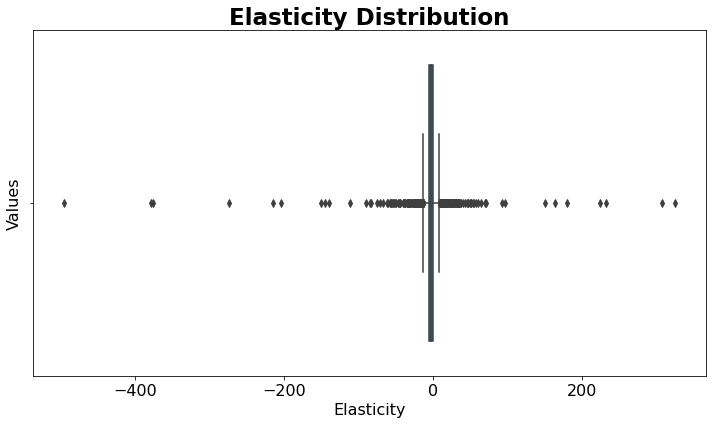

In [144]:
plt.figure(figsize=(10,6))
sns.boxplot(df_elasticity.Elasticity, orient='v')
plt.ylabel("Values",fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Elasticity',fontsize=16)
plt.title("Elasticity Distribution",fontsize=23,fontweight="bold")
plt.tight_layout()
plt.show();

In [148]:
dd=df_elasticity.head()

In [145]:
df_elasticity['Elasticity'].describe()

count    3022.000000
mean       -2.601547
std        21.863480
min      -496.261224
25%        -5.105185
50%        -2.303980
75%         0.283173
max       324.943165
Name: Elasticity, dtype: float64

In [142]:
df_elasticity.to_csv('df_elasticity.csv')